## Importação de bibliotecas e dados


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputRegressor


In [20]:
X_train = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/X_train.csv', index_col='cut_index')
y_train = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/y_train.csv')
y_train.set_index(X_train.index.values, inplace=True)
X_test = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/X_test.csv', index_col='cut_index')
y_test = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/y_test.csv')
y_test.set_index(X_test.index.values, inplace=True)

In [21]:
X_train['flute_1_lag1'] = y_train['flute_1'].shift(1).bfill()#fillna(method='bfill')
X_train['flute_1_lag2'] = y_train['flute_1'].shift(2).bfill()
X_train['flute_1_lag3'] = y_train['flute_1'].shift(3).bfill()

X_train['flute_2_lag1'] = y_train['flute_2'].shift(1).bfill()
X_train['flute_2_lag2'] = y_train['flute_2'].shift(2).bfill()
X_train['flute_2_lag3'] = y_train['flute_2'].shift(3).bfill()

X_train['flute_3_lag1'] = y_train['flute_3'].shift(1).bfill()
X_train['flute_3_lag2'] = y_train['flute_3'].shift(2).bfill()
X_train['flute_3_lag3'] = y_train['flute_3'].shift(3).bfill()

X_test['flute_1_lag1'] = y_test['flute_1'].shift(1).bfill()
X_test['flute_1_lag2'] = y_test['flute_1'].shift(2).bfill()
X_test['flute_1_lag3'] = y_test['flute_1'].shift(3).bfill()

X_test['flute_2_lag1'] = y_test['flute_2'].shift(1).bfill()
X_test['flute_2_lag2'] = y_test['flute_2'].shift(2).bfill()
X_test['flute_2_lag3'] = y_test['flute_2'].shift(3).bfill()

X_test['flute_3_lag1'] = y_test['flute_3'].shift(1).bfill()
X_test['flute_3_lag2'] = y_test['flute_3'].shift(2).bfill()
X_test['flute_3_lag3'] = y_test['flute_3'].shift(3).bfill()

In [22]:
# Selecionar apenas uma ferramenta
X_train_C1 = X_train.iloc[:315, :]
y_train_C1 = y_train.iloc[:315, :]
X_train_C2 = X_train.iloc[315:, :]
y_train_C2 = y_train.iloc[315:, :]

X_test_C6 = X_test.iloc[:315, :]
y_test_C6 = y_test.iloc[:315, :]

## Todas as features

In [6]:
selected_features = X_train_C1.columns.to_list()

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Definindo os parâmetros para o GridSearchCV com Random Forest
param_grid = {
    'regressor__estimator__n_estimators': [50, 100, 200],        # Número de árvores na floresta
    'regressor__estimator__max_depth': [None, 10, 20, 30],       # Profundidade máxima de cada árvore
    'regressor__estimator__min_samples_split': [2, 5, 10],       # Mínimo de amostras para dividir um nó
    'regressor__estimator__min_samples_leaf': [1, 2, 4]          # Mínimo de amostras em cada folha
}

# Definindo o pipeline para cada ferramenta com RandomForest
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1 e C2
for model, X_train_rfe, y_train, grid_search, name in [
    (grid_search_C1, X_train_C1_rfe, y_train_C1, grid_search_C1, "C1"),
    (grid_search_C2, X_train_C2_rfe, y_train_C2, grid_search_C2, "C2")
]:
    print(f"Performance em cada fold para o modelo {name}:")
    for i, (train_index, test_index) in enumerate(tscv.split(X_train_rfe)):
        X_train_fold, X_test_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        grid_search.best_estimator_.fit(X_train_fold, y_train_fold)
        y_pred_fold = grid_search.best_estimator_.predict(X_test_fold)

        mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
        r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

        print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")


Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.3s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.5s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.7s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.9s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_sp

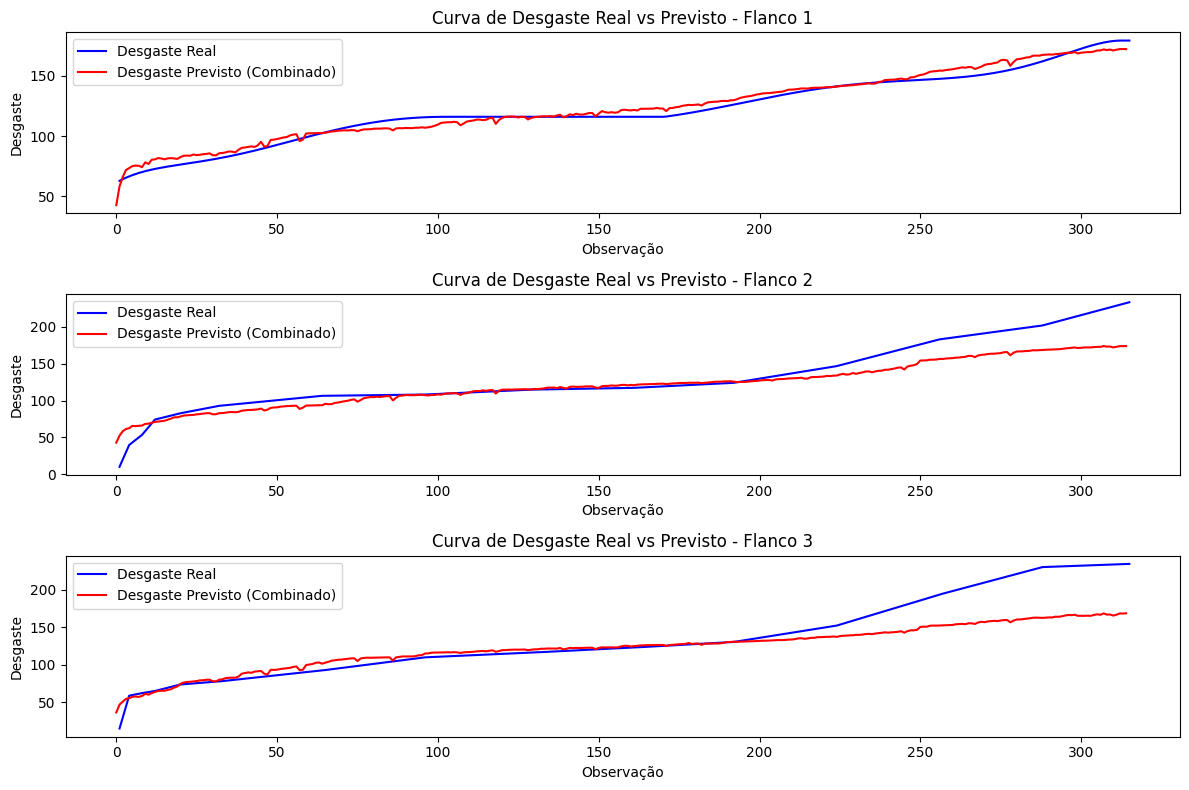

In [7]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

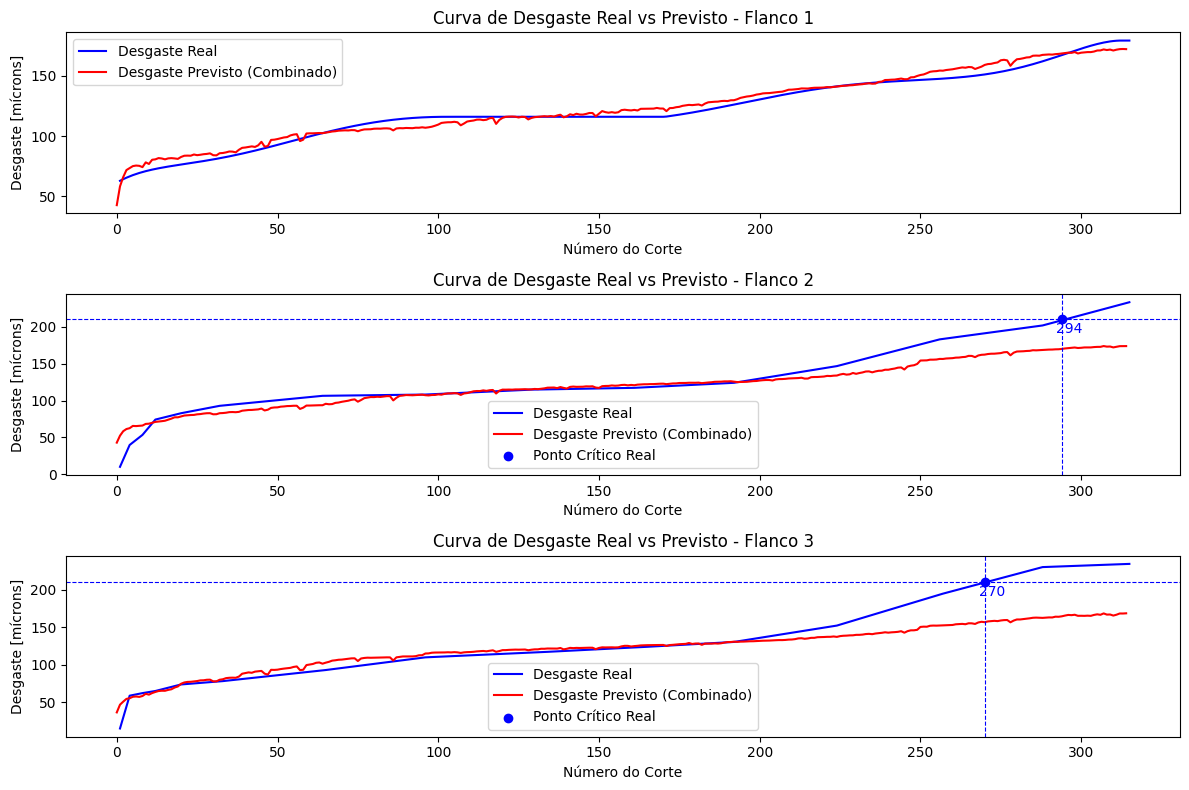

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Features de tempo

In [14]:
temporal_features = ['force_x_min', 'force_x_mean', 'force_x_std', 'force_x_kurtosis', 'force_y_max', 'force_y_std', 'force_z_max',
       'force_z_min', 'force_z_std', 'force_z_skewness', 'force_z_kurtosis',
       'acc_y_std', 'acc_y_rms', 'acc_z_std', 'acc_z_rms', 'force_x_mean_lag-1', 'force_x_std_lag-1', 'force_y_std_lag-1',
       'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag-1', 'flute_1_lag1',
       'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2',
       'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']

In [15]:
selected_features = temporal_features

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Definindo os parâmetros para o GridSearchCV com Random Forest
param_grid = {
    'regressor__estimator__n_estimators': [50, 100, 200],        # Número de árvores na floresta
    'regressor__estimator__max_depth': [None, 10, 20, 30],       # Profundidade máxima de cada árvore
    'regressor__estimator__min_samples_split': [2, 5, 10],       # Mínimo de amostras para dividir um nó
    'regressor__estimator__min_samples_leaf': [1, 2, 4]          # Mínimo de amostras em cada folha
}

# Definindo o pipeline para cada ferramenta com RandomForest
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1 e C2
for model, X_train_rfe, y_train, grid_search, name in [
    (grid_search_C1, X_train_C1_rfe, y_train_C1, grid_search_C1, "C1"),
    (grid_search_C2, X_train_C2_rfe, y_train_C2, grid_search_C2, "C2")
]:
    print(f"Performance em cada fold para o modelo {name}:")
    for i, (train_index, test_index) in enumerate(tscv.split(X_train_rfe)):
        X_train_fold, X_test_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        grid_search.best_estimator_.fit(X_train_fold, y_train_fold)
        y_pred_fold = grid_search.best_estimator_.predict(X_test_fold)

        mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
        r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

        print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")


Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.2s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.4s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.5s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.6s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_sp

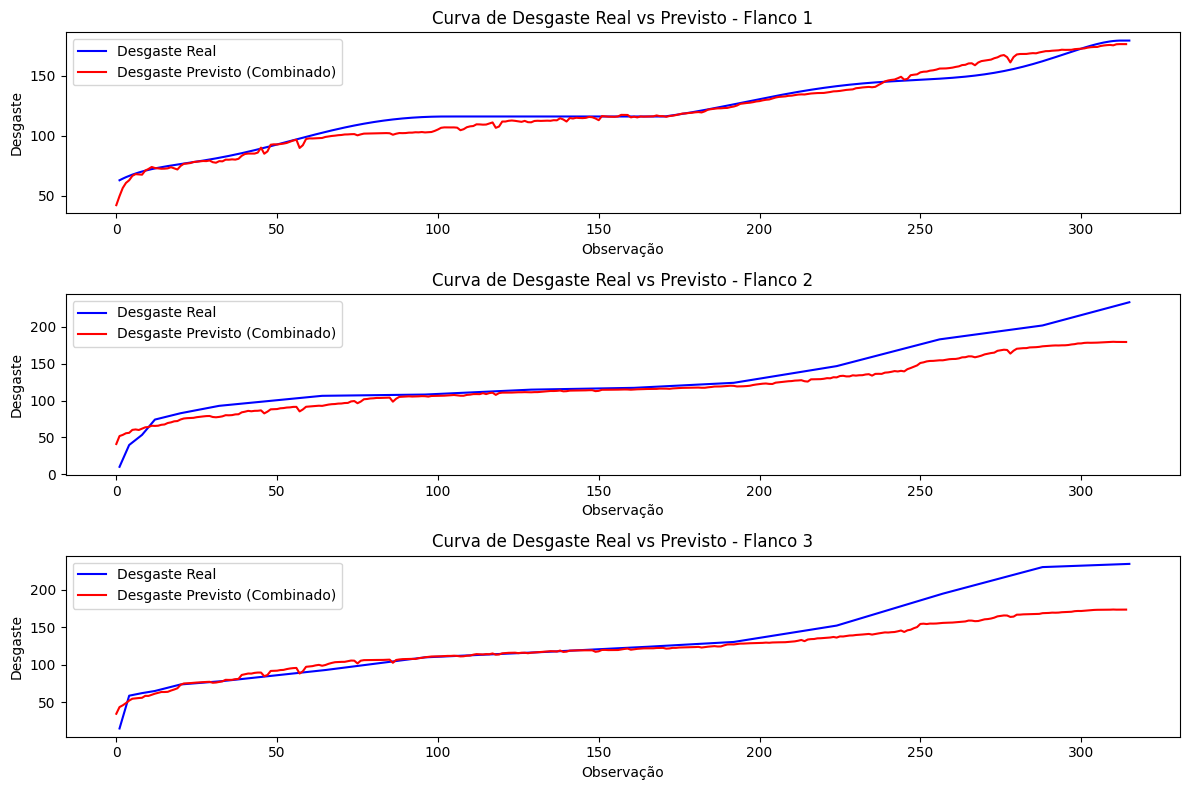

In [16]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

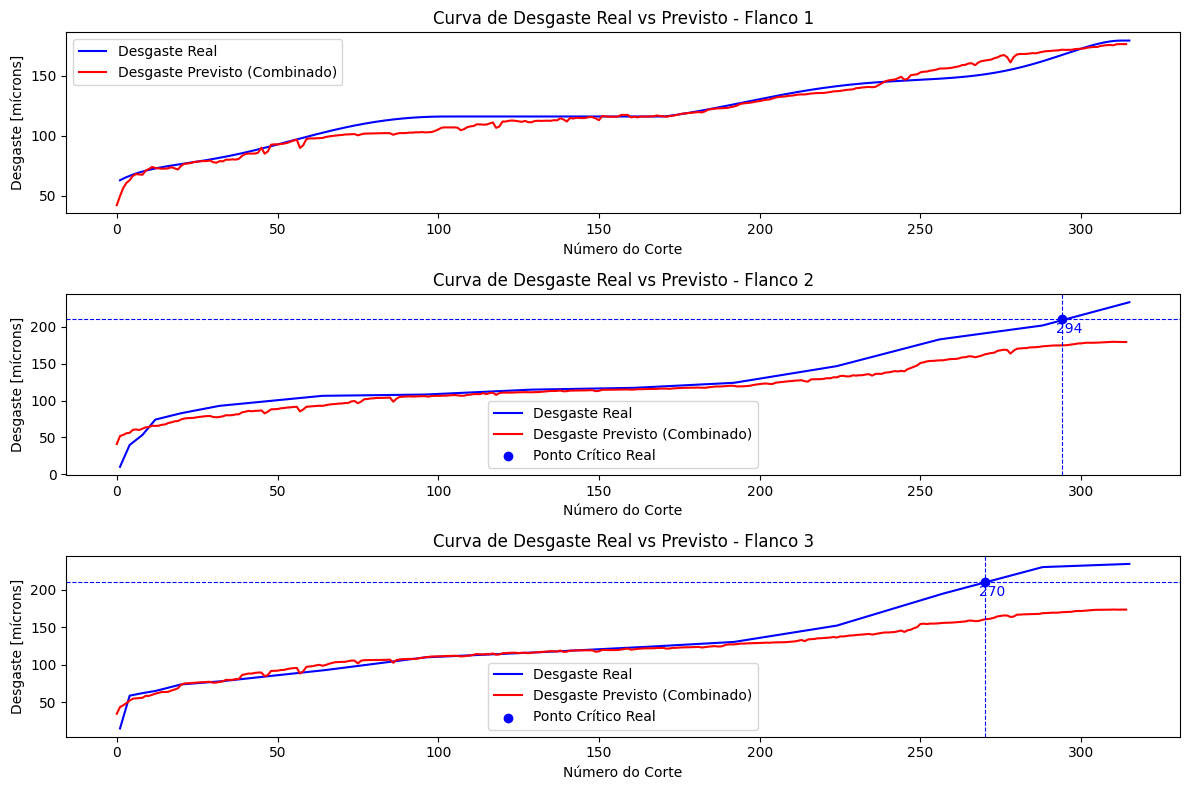

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Features de frequência

In [23]:
spectral_features = ['force_x_spectral_kurtosis',
       'force_y_spectral_kurtosis', 'force_y_spectral_skewness',
       'acc_x_spectral_centroid', 'acc_x_spectral_kurtosis',
       'acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_spectral_centroid',
       'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz',
       'acc_y_wavelet_energy_375.0Hz',
       'acc_z_spectral_kurtosis', 'acc_z_spectral_skewness',
       'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'flute_1_lag1',
       'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2',
       'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']

In [ ]:
selected_features = spectral_features

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Definindo os parâmetros para o GridSearchCV com Random Forest
param_grid = {
    'regressor__estimator__n_estimators': [50, 100, 200],        # Número de árvores na floresta
    'regressor__estimator__max_depth': [None, 10, 20, 30],       # Profundidade máxima de cada árvore
    'regressor__estimator__min_samples_split': [2, 5, 10],       # Mínimo de amostras para dividir um nó
    'regressor__estimator__min_samples_leaf': [1, 2, 4]          # Mínimo de amostras em cada folha
}

# Definindo o pipeline para cada ferramenta com RandomForest
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1 e C2
for model, X_train_rfe, y_train, grid_search, name in [
    (grid_search_C1, X_train_C1_rfe, y_train_C1, grid_search_C1, "C1"),
    (grid_search_C2, X_train_C2_rfe, y_train_C2, grid_search_C2, "C2")
]:
    print(f"Performance em cada fold para o modelo {name}:")
    for i, (train_index, test_index) in enumerate(tscv.split(X_train_rfe)):
        X_train_fold, X_test_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        grid_search.best_estimator_.fit(X_train_fold, y_train_fold)
        y_pred_fold = grid_search.best_estimator_.predict(X_test_fold)

        mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
        r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

        print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")


Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.2s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.3s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.4s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_split=2, regressor__estimator__n_estimators=50; total time=   0.5s
[CV] END regressor__estimator__max_depth=None, regressor__estimator__min_samples_leaf=1, regressor__estimator__min_samples_sp

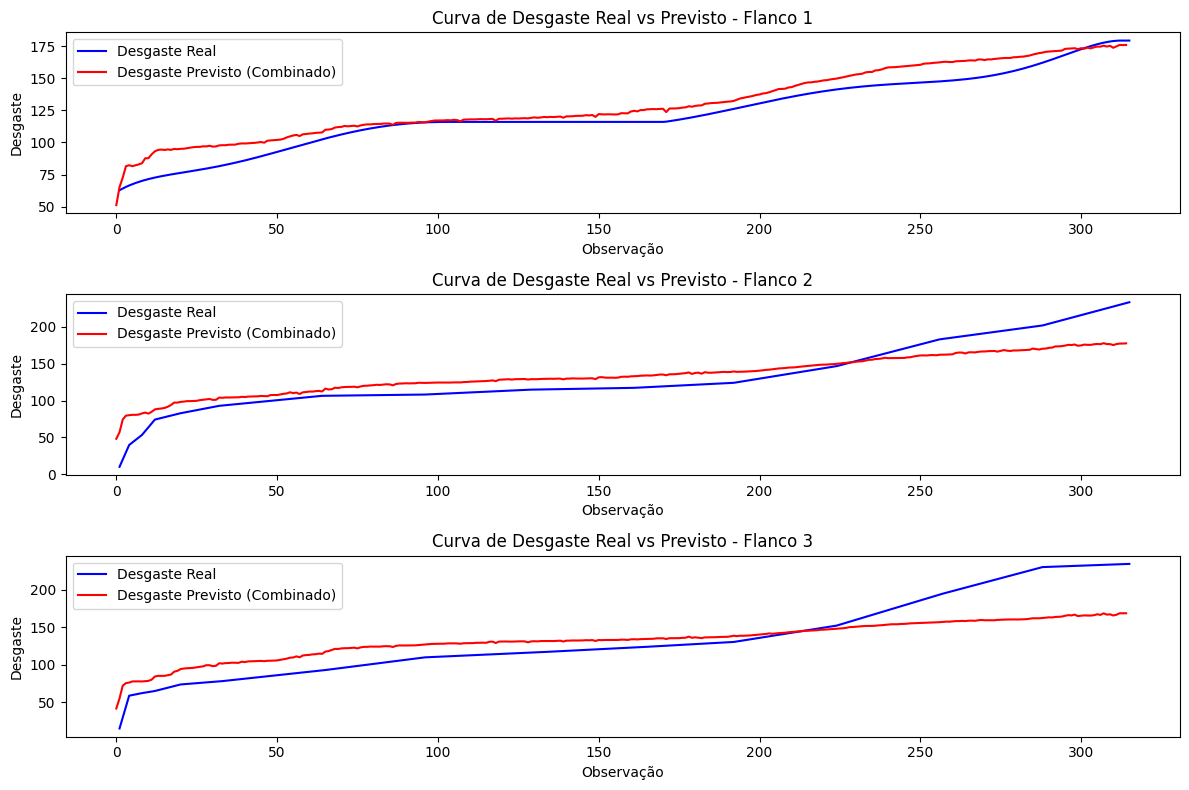

In [ ]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

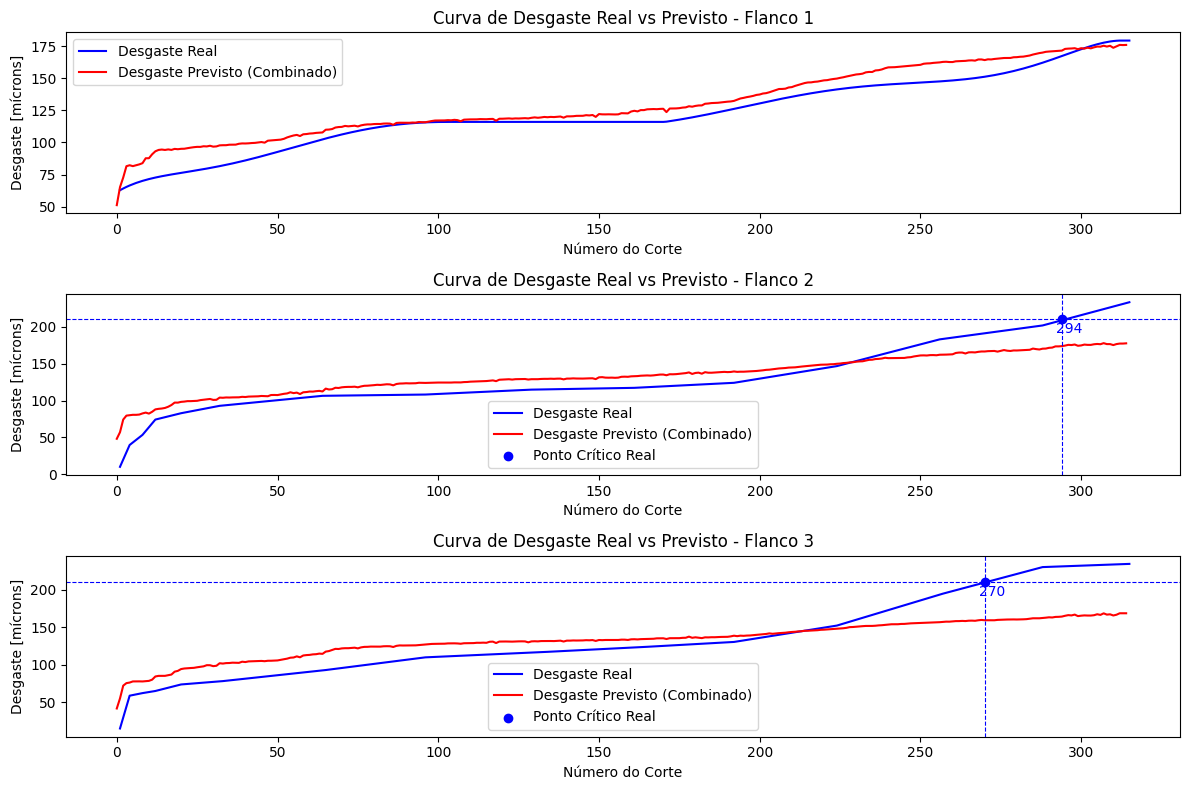

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Aplicação usando Bagging Regressor com modelo incremental

In [ ]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Configurar o Random Forest para cada subconjunto
rf_tool1 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)
rf_tool2 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=1)

# Definir a função para criar um Bagging Regressor específico para uma ferramenta
def create_bagging_regressor(base_estimator, X, y, n_estimators):
    return BaggingRegressor(estimator=base_estimator,
                            n_estimators=n_estimators,
                            random_state=42,
                            bootstrap=True).fit(X, y)

# Treinar Bagging Regressor para cada ferramenta
bagging_tool1 = create_bagging_regressor(rf_tool1, X_train_c1, y_train_c1, 50)
bagging_tool2 = create_bagging_regressor(rf_tool2, X_train_c2, y_train_c2, 50)

# Função para obter a previsão combinada dos dois Bagging Regressors
def combined_prediction(X):
    pred1 = bagging_tool1.predict(X)
    pred2 = bagging_tool2.predict(X)
    return (pred1 + pred2) / 2  # Média das previsões

# Listas para armazenar previsões one-step e valores reais
y_pred_one_step = []
y_real_one_step = list(y_test_c6)  # Conversão para lista para acesso incremental

# Armazenar as entradas de treinamento que serão atualizadas
X_train_c1_updated = X_train_c1.copy()
y_train_c1_updated = y_train_c1.copy()
X_train_c2_updated = X_train_c2.copy()
y_train_c2_updated = y_train_c2.copy()

# Loop para realizar One-Step Prediction
for i in range(len(X_test_c6)):
    # Seleciona o sample atual
    X_current = X_test_c6.iloc[i:i + 1]
    y_current_real = y_test_c6.iloc[i]

    # Realiza a previsão com o modelo atual
    y_current_pred = combined_prediction(X_current)
    y_pred_one_step.append(y_current_pred[0])  # Adiciona a previsão atual à lista de previsões

    # Atualiza os conjuntos de treino com a nova observação
    X_train_c1_updated = pd.concat([X_train_c1_updated, X_current], ignore_index=True)
    y_train_c1_updated = pd.concat([y_train_c1_updated, pd.DataFrame(y_current_real).T], axis=0, ignore_index=True)

    # Treina novamente o modelo Bagging com os dados atualizados apenas uma vez
    bagging_tool1 = create_bagging_regressor(rf_tool1, X_train_c1_updated, y_train_c1_updated, 50)
    bagging_tool2 = create_bagging_regressor(rf_tool2, X_train_c2_updated, y_train_c2_updated, 50)
    print(i)

# Avaliação dos resultados de One-Step Prediction
mse_one_step = mean_squared_error(y_test_c6, np.array(y_pred_one_step))
r2_one_step = r2_score(y_test_c6, np.array(y_pred_one_step))
mape_one_step = mean_absolute_percentage_error(y_test_c6, np.array(y_pred_one_step))

# Exibir os resultados
print("Desempenho com One-Step Prediction")
print(f"MSE: {mse_one_step:.4f}, R²: {r2_one_step:.4f}, MAPE: {mape_one_step:.4f}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

ValueError: Found input variables with inconsistent numbers of samples: [3, 315]

In [ ]:
# Avaliação dos resultados de One-Step Prediction
mse_one_step = mean_squared_error(y_test_c6, np.array(y_pred_one_step))
r2_one_step = r2_score(y_test_c6, np.array(y_pred_one_step))
mape_one_step = mean_absolute_percentage_error(y_test_c6, np.array(y_pred_one_step))

# Exibir os resultados
print("Desempenho com One-Step Prediction")
print(f"MSE: {mse_one_step:.4f}, R²: {r2_one_step:.4f}, MAPE: {mape_one_step:.4f}")

Desempenho com One-Step Prediction
MSE: 140.0697, R²: 0.9299, MAPE: 0.0660


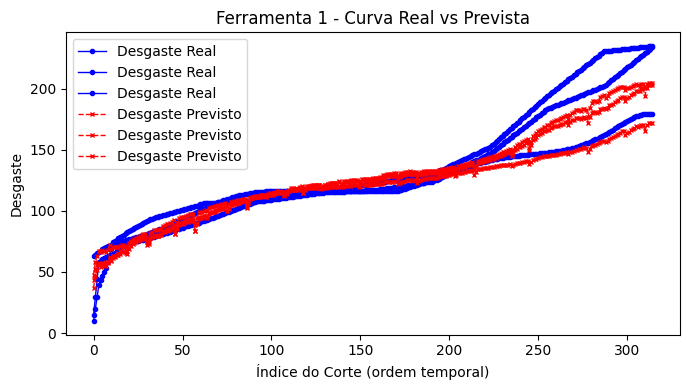

In [ ]:
# Visualização das curvas de desgaste real e prevista
plt.figure(figsize=(7, 4))

plt.plot(y_test_c6.values, label="Desgaste Real", color='blue', marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(np.array(y_pred_one_step), label="Desgaste Previsto", color='red', marker='x', markersize=3, linestyle='--', linewidth=1)
plt.title("Ferramenta 1 - Curva Real vs Prevista")
plt.xlabel("Índice do Corte (ordem temporal)")
plt.ylabel("Desgaste")
plt.legend()
plt.tight_layout()
plt.show()

## Aplicação usando Bagging Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Configurar o Random Forest para cada subconjunto
rf_tool1 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)
rf_tool2 = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=1)

# Treinar o Bagging Regressor
# Definindo 50% das árvores treinando com dados da ferramenta 1 e 50% com dados da ferramenta 2
bagging_estimators = 100  # Total de árvores
estimators_tool1 = 50  # Quantidade de árvores que verão os dados da ferramenta 1
estimators_tool2 = bagging_estimators - estimators_tool1  # Restante das árvores para ferramenta 2

# Função para criar um Bagging Regressor específico para uma ferramenta
def create_bagging_regressor(base_estimator, X, y, n_estimators):
    return BaggingRegressor(estimator=base_estimator,
                            n_estimators=n_estimators,
                            random_state=42,
                            bootstrap=True).fit(X, y)

# Treinar Bagging Regressor para cada ferramenta
bagging_tool1 = create_bagging_regressor(rf_tool1, X_train_c1, y_train_c1, estimators_tool1)
bagging_tool2 = create_bagging_regressor(rf_tool2, X_train_c2, y_train_c2, estimators_tool2)

# Função para obter a previsão combinada dos dois Bagging Regressors
def combined_prediction(X):
    pred1 = bagging_tool1.predict(X)
    pred2 = bagging_tool2.predict(X)
    return (pred1 + pred2) / 2  # Média das previsões

# Avaliação no conjunto de teste de cada ferramenta
# Ferramenta 1
y_pred_test1 = combined_prediction(X_test_c6)
mse_tool1 = mean_squared_error(y_test_c6, y_pred_test1)
r2_tool1 = r2_score(y_test_c6, y_pred_test1)
mape_tool1 = mean_absolute_percentage_error(y_test_c6, y_pred_test1)

# Ferramenta 2
y_pred_test2 = combined_prediction(X_test_c6)
mse_tool2 = mean_squared_error(y_test_c6, y_pred_test2)
r2_tool2 = r2_score(y_test_c6, y_pred_test2)
mape_tool2 = mean_absolute_percentage_error(y_test_c6, y_pred_test1)

# Exibir os resultados
print("Desempenho no conjunto de teste - Ferramenta 1")
print(f"MSE: {mse_tool1:.4f}, R²: {r2_tool1:.4f}, MAPE: {mape_tool1:.4f}")
print("\nDesempenho no conjunto de teste - Ferramenta 2")
print(f"MSE: {mse_tool2:.4f}, R²: {r2_tool2:.4f}, MAPE: {mape_tool2:.4f}")

Desempenho no conjunto de teste - Ferramenta 1
MSE: 516.4774, R²: 0.7607, MAPE: 0.0935

Desempenho no conjunto de teste - Ferramenta 2
MSE: 516.4774, R²: 0.7607, MAPE: 0.0935


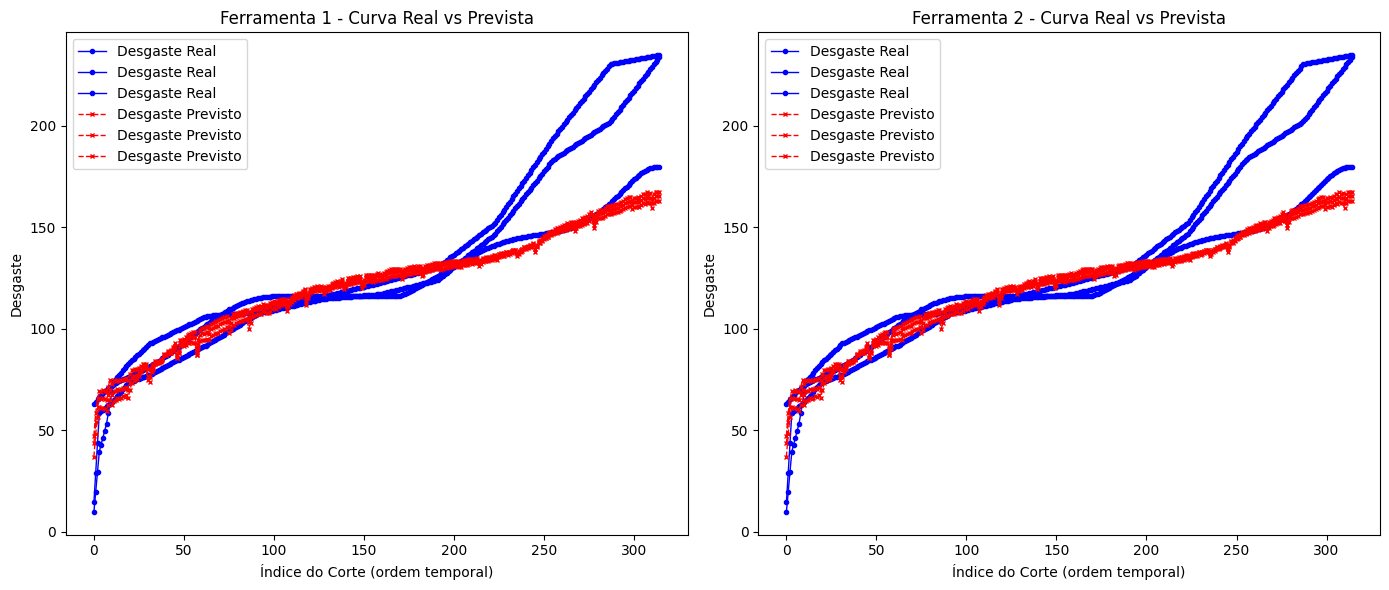

In [ ]:
# Visualização das curvas de desgaste real e prevista
plt.figure(figsize=(14, 6))

# Ferramenta 1
plt.subplot(1, 2, 1)
plt.plot(y_test_c6.values, label="Desgaste Real", color='blue', marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(y_pred_test1, label="Desgaste Previsto", color='red', marker='x', markersize=3, linestyle='--', linewidth=1)
plt.title("Ferramenta 1 - Curva Real vs Prevista")
plt.xlabel("Índice do Corte (ordem temporal)")
plt.ylabel("Desgaste")
plt.legend()

# Ferramenta 2
plt.subplot(1, 2, 2)
plt.plot(y_test_c6.values, label="Desgaste Real", color='blue', marker='o', markersize=3, linestyle='-', linewidth=1)
plt.plot(y_pred_test2, label="Desgaste Previsto", color='red', marker='x', markersize=3, linestyle='--', linewidth=1)
plt.title("Ferramenta 2 - Curva Real vs Prevista")
plt.xlabel("Índice do Corte (ordem temporal)")
plt.ylabel("Desgaste")
plt.legend()

plt.tight_layout()
plt.show()

## Aplicação usando todas as features e duas ferramentas

In [ ]:
# Adicionando coluna que indica a ferramenta
X_train['numero_ferramenta'] = np.where(X_train.index.values < 315, 1, 2)
X_test['numero_ferramenta'] = np.where(X_test.index.values < 315, 6, None)
X_train.head()
X_train.tail()
X_train[X_train['numero_ferramenta'] == 2];

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros encontrados: {'model__max_depth': 10, 'model__max_samples': 0.8, 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__n_estimators': 150}
MSE no teste final: 1051.9534243895025, R² no teste final: 0.30059163657906735, MAPE no teste final: 0.23759416399001343


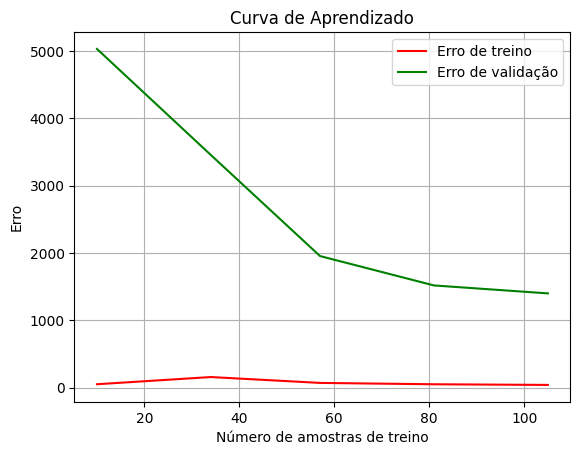

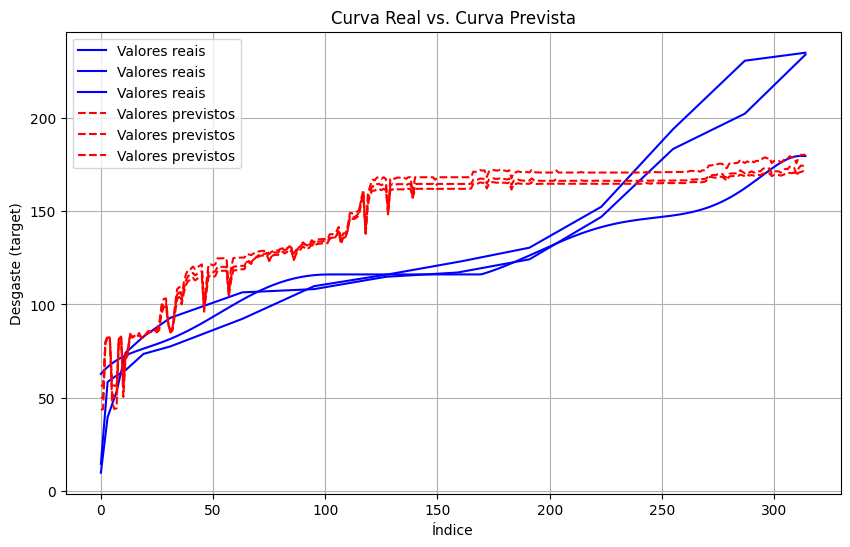

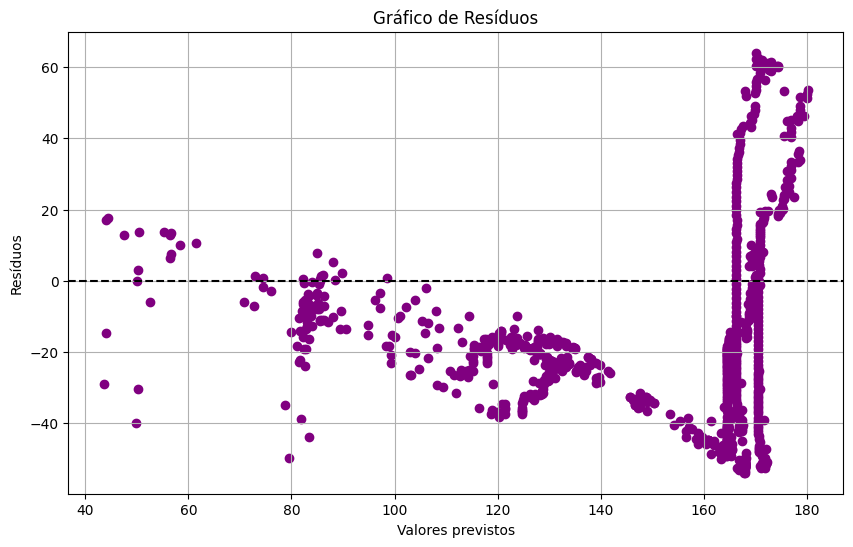

In [ ]:
# Defina as colunas numéricas e categóricas
cols = X_train.columns.to_list()
numeric_features = cols[1:-1]  # Supondo que a 1ª coluna seja index e a última seja target
non_numeric_features = ['numero_ferramenta']

# Pré-processamento: padronização apenas nas colunas numéricas (X)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# Criando o pipeline com preprocessor, RFE e RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Configurando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definindo a grid de parâmetros
param_grid = {
    'model__n_estimators': [50, 100, 150],  # Testando diferentes números de árvores no Random Forest
    'model__max_depth': [10, 20],  # Testando diferentes profundidades das árvores
    'model__min_samples_split': [15, 20],
    'model__min_samples_leaf': [15, 20],
    'model__max_samples': [0.6, 0.8]
}

# GridSearchCV para otimizar os parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar o modelo no conjunto de treinamento
grid_search.fit(X_train, y_train)  # Usar y_train escalado

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliação final no conjunto de teste
y_pred_final = best_model.predict(X_test)

# Cálculo das métricas no espaço original
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)
final_mape = mean_absolute_percentage_error(y_test, y_pred_final)

print(f'MSE no teste final: {final_mse}, R² no teste final: {final_r2}, MAPE no teste final: {final_mape}')

# -------------------------------------------------
# 1. CURVA DE APRENDIZADO
# -------------------------------------------------

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Erro de treino", color="r")
plt.plot(train_sizes, test_scores_mean, label="Erro de validação", color="g")
plt.title("Curva de Aprendizado")
plt.xlabel("Número de amostras de treino")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 2. CURVA REAL VS. CURVA PREVISTA
# -------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores reais', color='blue')
plt.plot(y_pred_final, label='Valores previstos', color='red', linestyle='--')
plt.title('Curva Real vs. Curva Prevista')
plt.xlabel('Índice')
plt.ylabel('Desgaste (target)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 3. GRÁFICO DE RESÍDUOS
# -------------------------------------------------

residuos = y_test - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuos, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores previstos')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()

<Axes: >

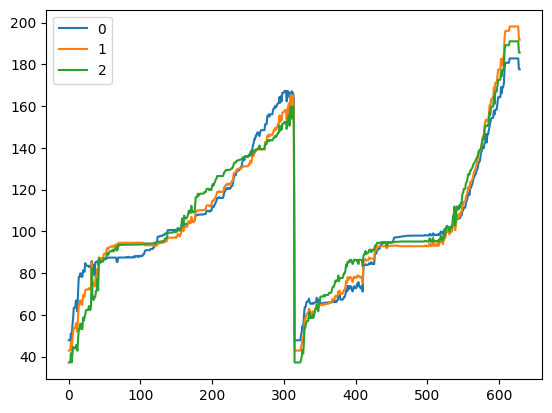

In [ ]:
y_train_final = best_model.predict(X_train)
b=pd.DataFrame(y_train_final)
b.plot()

## Aplicação usando todas as features

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import learning_curve

# Selecionar apenas uma ferramenta
X_train_c1 = X_train.iloc[:315, :]
y_train_c1 = y_train.iloc[:315, :]
X_test_c1 = X_test.iloc[:315, :]
y_test_c1 = y_test.iloc[:315, :]

NameError: name 'X_train' is not defined

In [ ]:
X_train_c2 = X_train.iloc[315:, :]
y_train_c2 = y_train.iloc[315:, :]
X_test_c2 = X_test.iloc[:315, :]
y_test_c2 = y_test.iloc[:315, :]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Defina as colunas numéricas e categóricas
cols = X_train_c2.columns.to_list()
numeric_features = cols[1:]  # Supondo que a 1ª coluna seja index e a última seja target
non_numeric_features = ['cut_index']

# Pré-processamento: padronização apenas nas colunas numéricas (X)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# Criando o pipeline com preprocessor, RFE e RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf)
])

# Configurando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definindo a grid de parâmetros
param_grid = {
    'model__n_estimators': [50, 100, 150],  # Testando diferentes números de árvores no Random Forest
    'model__max_depth': [10, 20],  # Testando diferentes profundidades das árvores
    'model__min_samples_split': [15, 20],
    'model__min_samples_leaf': [15, 20],
    'model__max_samples': [0.6, 0.8]
}

# GridSearchCV para otimizar os parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar o modelo no conjunto de treinamento
grid_search.fit(X_train_c2, y_train_c2)  # Usar y_train escalado

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliação final no conjunto de teste
y_pred_final = best_model.predict(X_test_c2)

# Cálculo das métricas no espaço original
final_mse = mean_squared_error(y_test_c2, y_pred_final)
final_r2 = r2_score(y_test_c2, y_pred_final)
final_mape = mean_absolute_percentage_error(y_test_c2, y_pred_final)

print(f'MSE no teste final: {final_mse}, R² no teste final: {final_r2}, MAPE no teste final: {final_mape}')

# -------------------------------------------------
# 1. CURVA DE APRENDIZADO
# -------------------------------------------------

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_c2, y_train_c2, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Erro de treino", color="r")
plt.plot(train_sizes, test_scores_mean, label="Erro de validação", color="g")
plt.title("Curva de Aprendizado")
plt.xlabel("Número de amostras de treino")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 2. CURVA REAL VS. CURVA PREVISTA
# -------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(y_test_c2.values, label='Valores reais', color='blue')
plt.plot(y_pred_final, label='Valores previstos', color='red', linestyle='--')
plt.title('Curva Real vs. Curva Prevista')
plt.xlabel('Índice')
plt.ylabel('Desgaste (target)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 3. GRÁFICO DE RESÍDUOS
# -------------------------------------------------

residuos = y_test_c2 - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuos, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores previstos')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()

In [ ]:
y_train_c2

In [ ]:
y_train_c2.plot()

In [ ]:
X_test_c2

In [ ]:
y_train_final = best_model.predict(X_train_c1)
b=pd.DataFrame(y_train_final)
b.plot()

## Aplicação com uma ferramenta + Normalização do Target

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import learning_curve

In [ ]:
# Selecionar apenas uma ferramenta
X_train_c1 = X_train.iloc[:315, :]
y_train_c1 = y_train.iloc[:315, :]
X_test_c1 = X_test.iloc[:315, :]
y_test_c1 = y_test.iloc[:315, :]

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros encontrados: {'feature_selection__n_features_to_select': 20, 'model__max_depth': 10, 'model__min_samples_leaf': 10, 'model__min_samples_split': 10, 'model__n_estimators': 20}
MSE no teste final: 703.289034713273, R² no teste final: 0.664619922846962, MAPE no teste final: 0.1205056617989428
Features selecionadas: Index(['cut_index', 'force_x_min', 'force_x_mean', 'force_y_max',
       'force_y_spectral_skewness', 'force_z_max', 'force_z_min',
       'force_z_skewness', 'acc_x_wavelet_energy_3000.0Hz',
       'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz',
       'acc_y_wavelet_energy_375.0Hz', 'acc_z_std', 'acc_z_spectral_skewness',
       'acc_z_wavelet_energy_1500.0Hz', 'force_x_mean_lag-1',
       'force_x_std_lag-1', 'acc_x_std_lag-1', 'acc_y_std_lag-1',
       'acc_z_std_lag-1'],
      dtype='object')


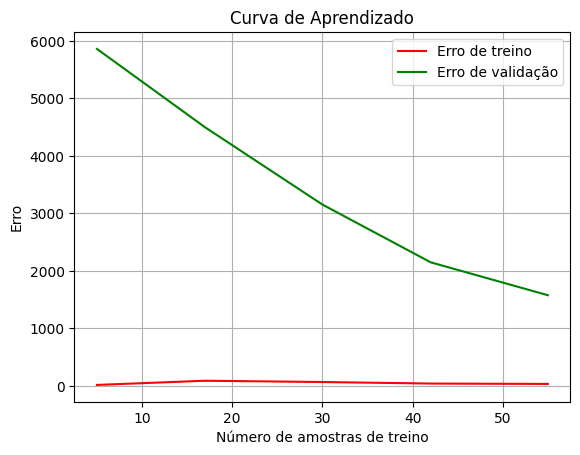

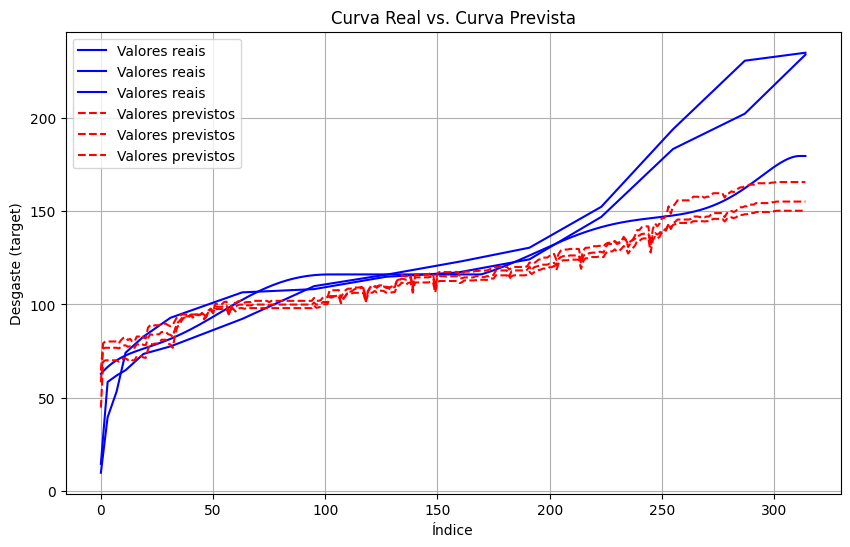

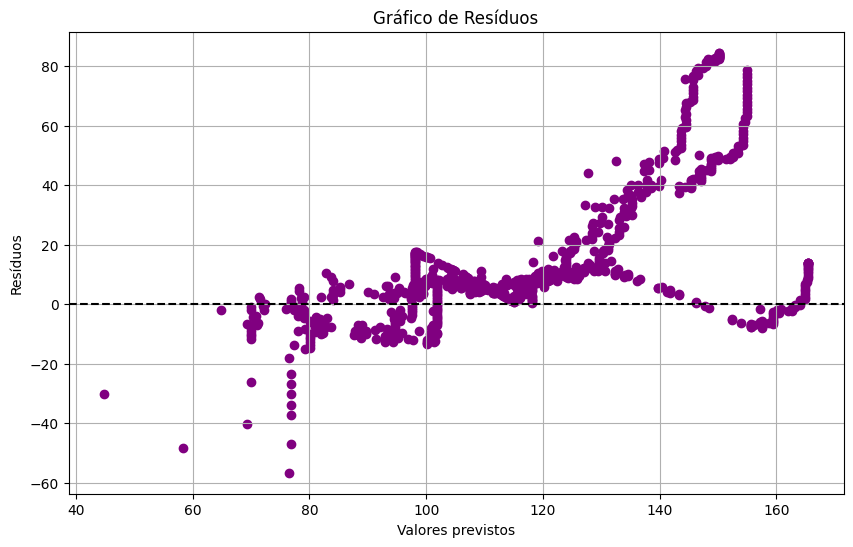

In [ ]:
from sklearn.preprocessing import StandardScaler

# Defina as colunas numéricas e categóricas
cols = X_train_c1.columns.to_list()
numeric_features = cols[1:]  # Supondo que a 1ª coluna seja index e a última seja target
non_numeric_features = ['cut_index']

# Pré-processamento: padronização apenas nas colunas numéricas (X)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Adicionando o StandardScaler para y_train e y_test (target)
scaler_y = StandardScaler()

# Padronizar o y_train
y_train_c1_scaled = scaler_y.fit_transform(y_train_c1.values)
y_test_c1_scaled = scaler_y.transform(y_test_c1.values)

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# RFE usando o Random Forest como estimador base
rfe = RFE(estimator=rf)

# Criando o pipeline com preprocessor, RFE e RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('model', rf)
])

# Configurando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definindo a grid de parâmetros
param_grid = {
    'feature_selection__n_features_to_select': [10, 15, 20],  # Testando diferentes números de features para o RFE
    'model__n_estimators': [10, 20, 50],  # Testando diferentes números de árvores no Random Forest
    'model__max_depth': [10, 20],  # Testando diferentes profundidades das árvores
    'model__min_samples_split': [10, 20],
    'model__min_samples_leaf': [10, 20]
}

# GridSearchCV para otimizar os parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar o modelo no conjunto de treinamento
grid_search.fit(X_train_c1, y_train_c1_scaled)  # Usar y_train escalado

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliação final no conjunto de teste
y_pred_scaled = best_model.predict(X_test_c1)

# Inverter a padronização para y_test e y_pred para trazer de volta ao espaço original
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)
y_test_c1_original = scaler_y.inverse_transform(y_test_c1_scaled)

# Cálculo das métricas no espaço original
final_mse = mean_squared_error(y_test_c1_original, y_pred_final)
final_r2 = r2_score(y_test_c1_original, y_pred_final)
final_mape = mean_absolute_percentage_error(y_test_c1_original, y_pred_final)

print(f'MSE no teste final: {final_mse}, R² no teste final: {final_r2}, MAPE no teste final: {final_mape}')

# Verificar as features selecionadas pelo RFE
selected_features = X_train_c1.columns[best_model.named_steps['feature_selection'].support_]
print(f'Features selecionadas: {selected_features}')

# -------------------------------------------------
# 1. CURVA DE APRENDIZADO
# -------------------------------------------------

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_c1, y_train_c1, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Erro de treino", color="r")
plt.plot(train_sizes, test_scores_mean, label="Erro de validação", color="g")
plt.title("Curva de Aprendizado")
plt.xlabel("Número de amostras de treino")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 2. CURVA REAL VS. CURVA PREVISTA
# -------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(y_test_c1.values, label='Valores reais', color='blue')
plt.plot(y_pred_final, label='Valores previstos', color='red', linestyle='--')
plt.title('Curva Real vs. Curva Prevista')
plt.xlabel('Índice')
plt.ylabel('Desgaste (target)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 3. GRÁFICO DE RESÍDUOS
# -------------------------------------------------

residuos = y_test_c1 - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuos, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores previstos')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()

In [ ]:
train_sizes

NameError: name 'train_sizes' is not defined

## Aplicação com variável categóriga + timeseries split usando duas ferramentas ao mesmo tempo

In [ ]:
# Adicionando coluna que indica a ferramenta
X_train['numero_ferramenta'] = np.where(X_train.index.values < 315, 1, 2)
X_test['numero_ferramenta'] = np.where(X_test.index.values < 315, 6)
#X_train.head()
#X_train.tail()
#X_train[X_train['numero_ferramenta'] == 1]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

# Defina as colunas numéricas e categóricas
cols = X_train.columns.to_list()
numeric_features = cols[1:-1]  # Supondo que a 1ª coluna seja index e a última seja target
non_numeric_features = ['cut_index', 'numero_ferramenta']

# Pré-processamento: padronização apenas nas colunas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# RFE usando o Random Forest como estimador base
rfe = RFE(estimator=rf)

# Criando o pipeline com preprocessor, RFE e RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('model', rf)
])

# Configurando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definindo a grid de parâmetros
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15],  # Testando diferentes números de features para o RFE
    'model__n_estimators': [100, 200],  # Testando diferentes números de árvores no Random Forest
    'model__max_depth': [10, 20]  # Testando diferentes profundidades das árvores
}

# GridSearchCV para otimizar os parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar o modelo no conjunto de treinamento
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliação final no conjunto de teste
y_pred_final = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)
final_mape = mean_absolute_percentage_error(y_test, y_pred_final)

print(f'MSE no teste final: {final_mse}, R² no teste final: {final_r2}, MAPE no teste final: {final_mape}')

# Verificar as features selecionadas pelo RFE
selected_features = X_train.columns[best_model.named_steps['feature_selection'].support_]
print(f'Features selecionadas: {selected_features}')

Melhores parâmetros encontrados: {'feature_selection__n_features_to_select': 5, 'model__max_depth': 20, 'model__n_estimators': 100}
MSE no teste final: 2306.2175175625293, R² no teste final: -0.6016259036287495, MAPE no teste final: 0.3634091556791505
Features selecionadas: Index(['acc_x_wavelet_energy_1500.0Hz', 'acc_y_std',
       'acc_z_wavelet_energy_3000.0Hz', 'acc_x_std_lag-1', 'acc_y_std_lag-1'],
      dtype='object')


<Axes: >

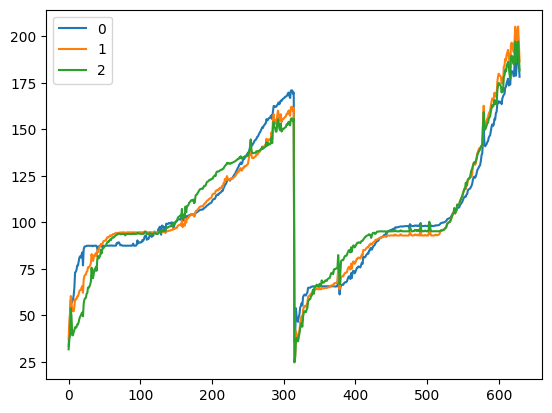

In [ ]:
y_train_final = best_model.predict(X_train)
b=pd.DataFrame(y_train_final)
b.plot()

<Axes: >

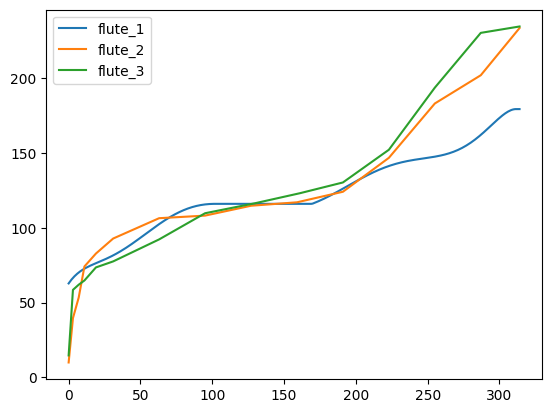

In [ ]:
y_test.plot()

<Axes: >

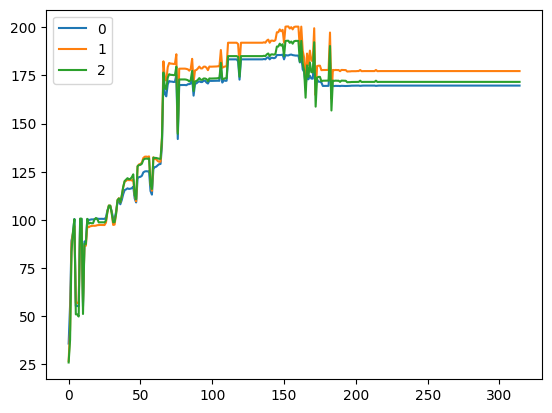

In [ ]:
a = pd.DataFrame(y_pred_final)
a.plot()

In [ ]:
cols = X_train.columns.to_list()

# Pré-processamento: padronização apenas nas colunas numéricas
numeric_features = cols[1:-1]
non_numeric_features = ['cut_index', 'numero_ferramenta']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# RFE usando o Random Forest como estimador base
rfe = RFE(estimator=rf)

# Criando o pipeline com preprocessor, RFE e RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('model', rf)
])

# Configurando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Treinando o modelo usando TimeSeriesSplit
for train_index, test_index in tscv.split(X_train):
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]

    '''Trecho que usei para verificar se cada subset contém mais de uma ferramenta.
    Dois últimos subsets sim, porém, a ordem das ferramentas não está embaralhada, então ok

    if X_train_split['numero_ferramenta'].nunique() == 1:
      print('oi')
    else:
      print('nao')
      a = X_train_split
    if X_test_split['numero_ferramenta'].nunique() == 1:
      print('oi')
    a.numero_ferramenta.plot()
    '''
    pipeline.fit(X_train_split, y_train_split)

    # Avaliação do modelo
    y_pred = pipeline.predict(X_test_split)
    mse = mean_squared_error(y_test_split, y_pred)
    r2 = r2_score(y_test_split, y_pred)
    mape = mean_absolute_percentage_error(y_test_split, y_pred)
    print(f'MSE: {mse}, R²: {r2}, MAPE: {mape}')

# Avaliação final no conjunto de teste
y_pred_final = pipeline.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred_final)
final_r2 = r2_score(y_test, y_pred_final)
final_mape = mean_absolute_percentage_error(y_test, y_pred_final)

print(f'MSE no teste final: {final_mse}, R² no teste final: {final_r2}, MAPE no teste final: {final_mape}')

MSE: 207.49640971399012, R²: -2.3161073574718447, MAPE: 10.249074909765573
MSE: 716.193910002443, R²: -2.842355640970498, MAPE: 14.916828367046492
MSE: 256.96046471527046, R²: -0.9293412329347537, MAPE: 23.991217957021963
MSE: 103.82063711924172, R²: -720.835722716807, MAPE: 8.455474678664196
MSE: 529.1505118612154, R²: 0.5244370167711752, MAPE: 8.869518022332434
MSE no teste final: 725.5138829310881, R² no teste final: 0.6460605773291479


## Aplicação sem variável categórica + timeseries split usando uma ferramenta apenas

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [ ]:
# Selecionar apenas uma ferramenta
X_train_c1 = X_train.iloc[:315, :]
y_train_c1 = y_train.iloc[:315, :]
X_test_c1 = X_test.iloc[:315, :]
y_test_c1 = y_test.iloc[:315, :]

In [ ]:
X_train_c1.head()

,cut_index,force_x_min,force_x_mean,force_x_std,force_x_kurtosis,force_x_spectral_kurtosis,force_y_max,force_y_std,force_y_spectral_kurtosis,force_y_spectral_skewness,...,acc_z_spectral_kurtosis,acc_z_spectral_skewness,acc_z_wavelet_energy_3000.0Hz,acc_z_wavelet_energy_1500.0Hz,force_x_mean_lag-1,force_x_std_lag-1,force_y_std_lag-1,acc_x_std_lag-1,acc_y_std_lag-1,acc_z_std_lag-1
0,1,-2.501,0.400857,0.842468,-0.245189,15.514857,10.724,1.635957,16.357184,3.443238,...,1.784035,-0.273639,0.056809,0.035125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,-4.219,1.028151,1.864977,0.022639,16.458729,14.302,3.149948,14.398200,3.141179,...,1.751312,-0.213026,0.065034,0.048705,0.400857,0.842468,1.635957,0.076349,0.076315,0.076564
2,3,-5.994,1.776092,2.672088,0.073317,17.521404,20.826,4.816019,13.801894,3.006207,...,1.701134,-0.096785,0.073131,0.069327,1.028151,1.864977,3.149948,0.085350,0.085027,0.086950
3,4,-6.157,2.104920,2.992555,0.102548,17.874697,24.148,5.532462,13.524783,2.961414,...,1.688453,-0.090994,0.075858,0.070204,1.776092,2.672088,4.816019,0.095641,0.093816,0.098038
4,5,-4.288,2.831384,2.979757,0.016936,17.556548,24.337,5.747379,13.643097,2.969246,...,1.679400,0.036798,0.061068,0.068448,2.104920,2.992555,5.532462,0.099032,0.097125,0.102088


In [ ]:
y_train

,flute_1,flute_2,flute_3
0,32.317114,48.892617,37.720825
1,37.914879,49.570815,37.720825
2,43.087910,50.302867,37.720825
3,47.859072,51.083652,37.849851
4,52.250329,51.908288,38.172665
...,...,...,...
625,191.527141,206.633895,198.454237
626,192.696201,207.724013,199.396303
627,193.859049,208.801783,200.326329
628,195.015359,209.866976,201.244141


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros encontrados: {'feature_selection__n_features_to_select': 10, 'model__max_depth': 10, 'model__min_samples_leaf': 10, 'model__min_samples_split': 10, 'model__n_estimators': 50}
MSE no teste final: 782.5194208090467, R² no teste final: 0.612240650228898, MAPE no teste final: 0.14120061358640545
Features selecionadas: Index(['force_x_mean', 'force_y_max', 'force_z_max', 'force_z_min',
       'acc_x_wavelet_energy_1500.0Hz', 'acc_y_wavelet_energy_375.0Hz',
       'force_x_mean_lag-1', 'force_x_std_lag-1', 'acc_x_std_lag-1',
       'acc_z_std_lag-1'],
      dtype='object')


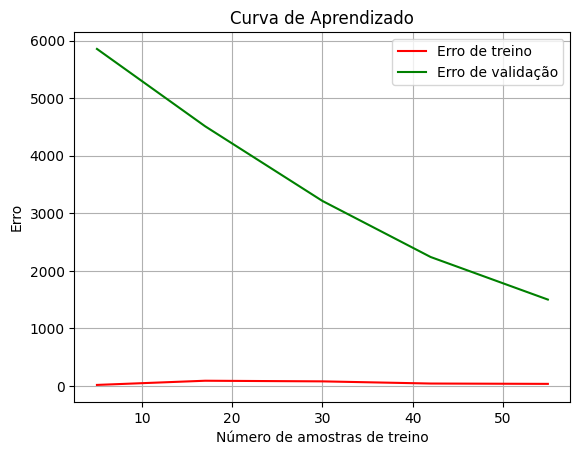

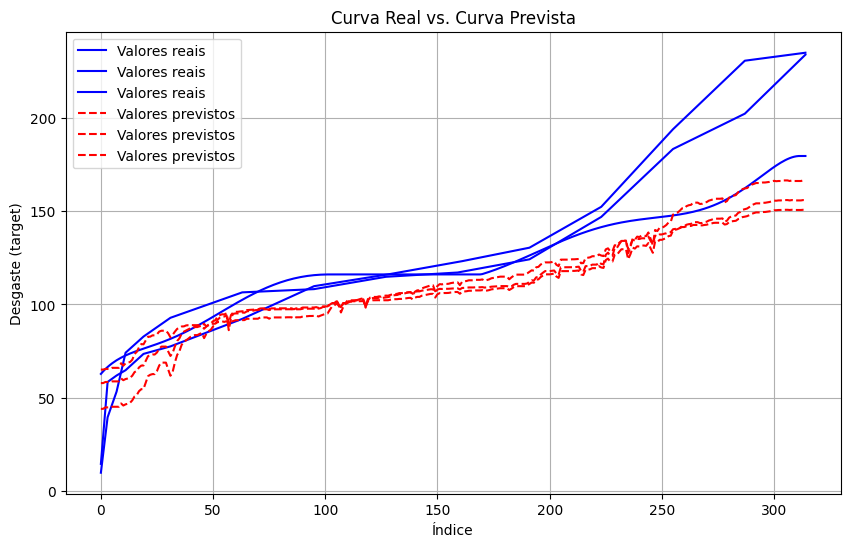

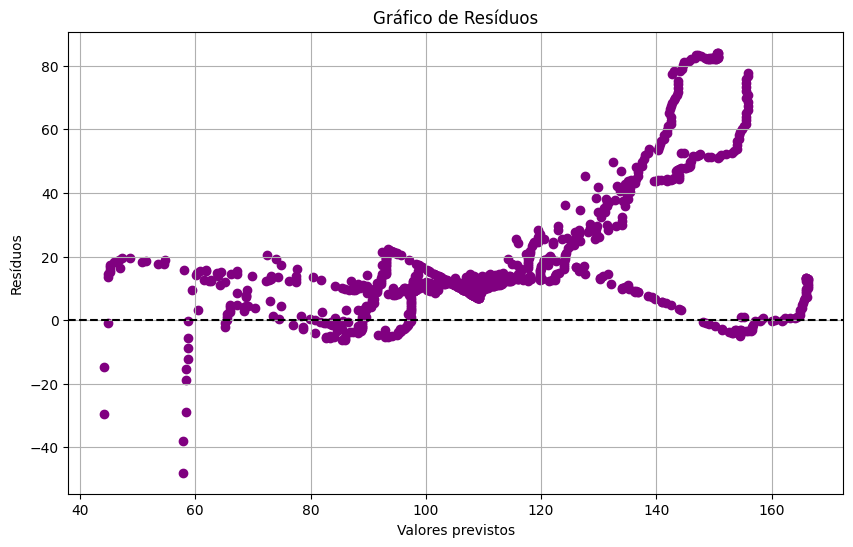

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import learning_curve

# Defina as colunas numéricas e categóricas
cols = X_train_c1.columns.to_list()
numeric_features = cols[1:]  # Supondo que a 1ª coluna seja index e a última seja target
non_numeric_features = ['cut_index']

# Pré-processamento: padronização apenas nas colunas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# RFE usando o Random Forest como estimador base
rfe = RFE(estimator=rf)

# Criando o pipeline com preprocessor, RFE e RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('model', rf)
])

# Configurando o TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definindo a grid de parâmetros
param_grid = {
    'feature_selection__n_features_to_select': [10, 15, 20],  # Testando diferentes números de features para o RFE
    'model__n_estimators': [10, 20, 50],  # Testando diferentes números de árvores no Random Forest
    'model__max_depth': [10, 20],  # Testando diferentes profundidades das árvores
    'model__min_samples_split': [10, 20],
    'model__min_samples_leaf': [10, 20]
}

# GridSearchCV para otimizar os parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajustar o modelo no conjunto de treinamento
grid_search.fit(X_train_c1, y_train_c1)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Avaliação final no conjunto de teste
y_pred_final = best_model.predict(X_test_c1)
final_mse = mean_squared_error(y_test_c1, y_pred_final)
final_r2 = r2_score(y_test_c1, y_pred_final)
final_mape = mean_absolute_percentage_error(y_test_c1, y_pred_final)

print(f'MSE no teste final: {final_mse}, R² no teste final: {final_r2}, MAPE no teste final: {final_mape}')

# Verificar as features selecionadas pelo RFE
selected_features = X_train_c1.columns[best_model.named_steps['feature_selection'].support_]
print(f'Features selecionadas: {selected_features}')

# -------------------------------------------------
# 1. CURVA DE APRENDIZADO
# -------------------------------------------------

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_c1, y_train_c1, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Erro de treino", color="r")
plt.plot(train_sizes, test_scores_mean, label="Erro de validação", color="g")
plt.title("Curva de Aprendizado")
plt.xlabel("Número de amostras de treino")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 2. CURVA REAL VS. CURVA PREVISTA
# -------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(y_test_c1.values, label='Valores reais', color='blue')
plt.plot(y_pred_final, label='Valores previstos', color='red', linestyle='--')
plt.title('Curva Real vs. Curva Prevista')
plt.xlabel('Índice')
plt.ylabel('Desgaste (target)')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------
# 3. GRÁFICO DE RESÍDUOS
# -------------------------------------------------

residuos = y_test_c1 - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuos, color='purple')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Valores previstos')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()

## Aplicação sem pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_modified = X_train.iloc[:,1:]
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test_[:,1:])

X_train = np.column_stack((X_train_scaled, X_train['cut_index'].values))
X_train

array([[-1.72656093e+00,  9.17082371e-01, -8.93977514e-01, ...,
        -3.03023470e+00, -3.32083463e+00,  1.00000000e+00],
       [-1.71556373e+00,  8.46810327e-01, -8.50890572e-01, ...,
        -1.02391602e+00, -1.47483823e+00,  2.00000000e+00],
       [-1.70456653e+00,  7.74206790e-01, -7.99516680e-01, ...,
        -7.94879070e-01, -1.22440855e+00,  3.00000000e+00],
       ...,
       [ 1.70456653e+00, -1.75039204e+00,  2.16765451e-01, ...,
         1.34677437e+00,  1.31254032e+00,  3.13000000e+02],
       [ 1.71556373e+00, -1.72400935e+00,  2.24202906e-01, ...,
         1.29664515e+00,  1.19479451e+00,  3.14000000e+02],
       [ 1.72656093e+00, -1.78389193e+00,  2.33258048e-01, ...,
         1.26623184e+00,  1.14940608e+00,  3.15000000e+02]])

In [ ]:
X_test_modified = X_test.iloc[:,1:]
X_test_scaled = scaler.transform(X_test)
X_test = np.column_stack((X_test_scaled, X_test['cut_index'].values))
X_test

array([[ -1.72656093,   0.92501763,  -0.8820701 , ...,  -3.0302347 ,
         -3.32083463,   1.        ],
       [ -1.71556373,   0.87830595,  -0.81084213, ...,  -1.38006975,
         -1.78253529,   2.        ],
       [ -1.70456653,   0.85842689,  -0.75124111, ...,  -0.90835159,
         -1.30280738,   3.        ],
       ...,
       [  1.70456653,  -1.98603654,   0.41432368, ...,   7.98915234,
          9.76681556, 313.        ],
       [  1.71556373,  -1.9927447 ,   0.42272726, ...,   7.92620013,
          9.59407629, 314.        ],
       [  1.72656093,  -1.94415146,   0.43503949, ...,   7.93879411,
          9.52711249, 315.        ]])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R²: {r2}")

MSE: 862.3330510350488, R²: 0.47969289863061243


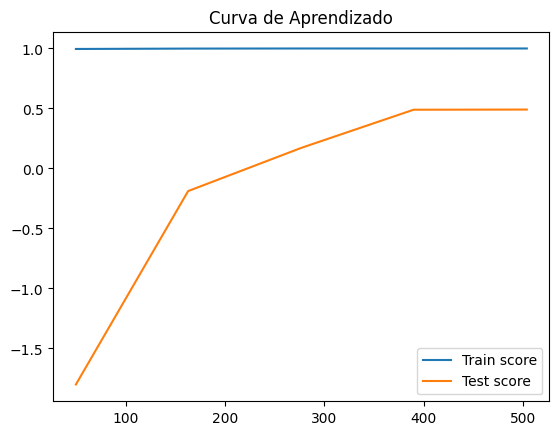

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train score")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Test score")
plt.legend()
plt.title("Curva de Aprendizado")
plt.show()

## Aplicação como pipeline



In [ ]:
cols = X_train.columns.to_list()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Separando 'cut_index' das demais colunas para distinguir padronização
numeric_features = cols[1:]
non_numeric_features = [cols[0]]

# Criando um transformer que aplica padronização nas colunas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('non_num', 'passthrough', non_numeric_features)  # 'passthrough' deixa essa coluna inalterada
    ])

# Aplicando o preprocessor em um pipeline com RandomForest
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42))])

# Treinando o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['force_x_min',
                                                   'force_x_mean',
                                                   'force_x_std',
                                                   'force_x_kurtosis',
                                                   'force_x_spectral_kurtosis',
                                                   'force_y_max', 'force_y_std',
                                                   'force_y_spectral_kurtosis',
                                                   'force_y_spectral_skewness',
                                                   'force_z_max', 'force_z_min',
                                                   'force_z_std',
                                                   'force_z_skewness',
                                                   'force_z_kurtosis',
                                                   'acc_x_...
                                                   'acc_y_spectral_centroid',
                                                   'acc_y_spectral_skewness',
                                                   'acc_y_wavelet_energy_3000.0Hz',
                                                   'acc_y_wavelet_energy_375.0Hz',
                                                   'acc_z_std', 'acc_z_rms',
                                                   'acc_z_spectral_kurtosis',
                                                   'acc_z_spectral_skewness',
                                                   'acc_z_wavelet_energy_3000.0Hz',
                                                   'acc_z_wavelet_energy_1500.0Hz', ...]),
                                                 ('non_num', 'passthrough',
                                                  ['cut_index'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
# Fazendo previsões nos dados de teste
y_pred = pipeline.predict(X_test)

# Avaliando a performance do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 851.8182896688312
R² Score: 0.4893028351095559


In [ ]:
# Avaliando o desempenho nos dados de treino
y_train_pred = pipeline.predict(X_train)

# Erros nos dados de treino e teste
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Erro nos dados de treino: {mse_train}")
print(f"Erro nos dados de teste: {mse_test}")

Erro nos dados de treino: 0.5154629249930255
Erro nos dados de teste: 851.8182896688312


<Axes: >

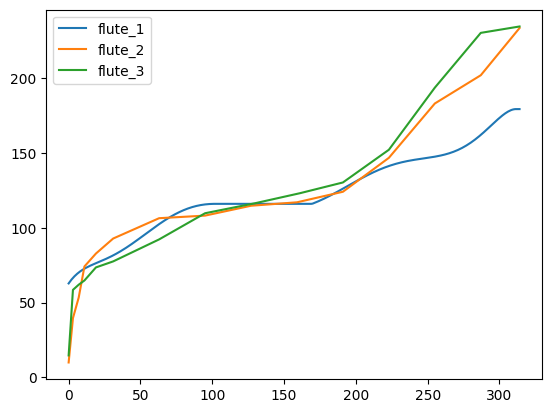

In [ ]:
import matplotlib.pyplot as plt
y_test.plot()

In [ ]:
a = pd.DataFrame(y_pred)
a

,0,1,2
0,41.450098,39.461429,34.370742
1,46.071109,47.592347,39.450280
2,84.803559,83.579494,81.527147
3,85.988904,86.220488,84.220614
4,85.801068,84.940462,82.681732
...,...,...,...
310,168.753888,177.422861,171.877361
311,169.967734,178.739447,173.042070
312,170.613132,180.128284,174.372966
313,170.568908,179.822034,174.064605


<Axes: >

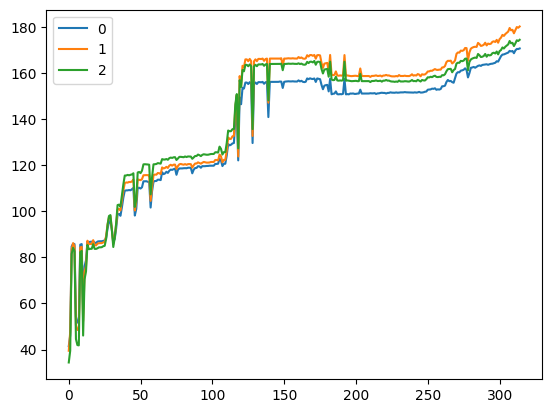

In [ ]:
a.plot()

In [ ]:
y_pred

array([[ 41.45009777,  39.46142857,  34.37074187],
       [ 46.07110868,  47.59234709,  39.45028049],
       [ 84.80355916,  83.57949436,  81.52714735],
       [ 85.98890407,  86.22048802,  84.22061441],
       [ 85.80106772,  84.94046177,  82.68173167],
       [ 54.20949119,  50.48741035,  44.55535634],
       [ 51.73317177,  48.53739235,  41.93767318],
       [ 51.73525893,  48.48187404,  41.80651678],
       [ 85.57613096,  84.35130722,  82.35038397],
       [ 85.8180426 ,  84.60010457,  82.82881499],
       [ 57.90635259,  52.30472594,  46.07114012],
       [ 76.17664366,  73.75870545,  70.53578024],
       [ 78.81311483,  76.24160613,  73.88099893],
       [ 86.84938043,  87.28484682,  85.45587414],
       [ 86.6884419 ,  85.76125245,  83.59207325],
       [ 86.81741104,  85.87928124,  83.74965798],
       [ 86.83820118,  85.89896503,  83.7690221 ],
       [ 87.02548906,  87.52168294,  85.7940452 ],
       [ 86.44208784,  85.43075716,  83.74285896],
       [ 86.30582969,  85.23692